<a href="https://colab.research.google.com/github/tingleica/FundingAnalysis/blob/main/New_MBSModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Load the data
data = pd.read_csv("/content/TBAHistoricalPrices-AI.csv")
data.head()

# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Summary of categorical variables
categorical_summary = data.select_dtypes(include=['object']).describe()

missing_values, categorical_summary


# Drop specified fields
data_cleaned = data.drop(['Date', 'Settlement Month', 'Settlement Date'], axis=1)

# One-hot encode the 'Agency' and 'Term' categorical columns
data_encoded = pd.get_dummies(data_cleaned, columns=['Agency', 'Term'])

# Separate features and target variable
X = data_encoded.drop('Price', axis=1)
y = data_encoded['Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=15, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and calculate the Mean Absolute Error on the test set
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print (mae)

# Now, let's rank the feature contributions (feature importances) from the Random Forest model
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

feature_importances_df




0.22592559837241205


,Feature,Importance
0,Coupon,0.449810
6,3Y,0.312545
10,20Y,0.071889
7,5Y,0.043194
8,7Y,0.019044
9,10Y,0.018299
17,Term_15Y,0.018098
18,Term_30Y,0.018034
5,2Y,0.010914
11,30Y,0.009431


In [ ]:
from xgboost import XGBRegressor

# Initialize and train the XGBoost Regressor with reduced n_estimators
xgb_model= XGBRegressor(n_estimators=15, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and calculate the Mean Absolute Error on the test set using the simplified XGBoost model
y_pred_xgb= xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(mae_xgb)

# Now, let's rank the feature contributions (feature importances) from the Random Forest model
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

feature_importances_df



0.4370256879041705


,Feature,Importance
6,3Y,0.489605
0,Coupon,0.142061
8,7Y,0.103454
10,20Y,0.078869
4,1Y,0.036864
17,Term_15Y,0.024837
9,10Y,0.022349
11,30Y,0.014837
7,5Y,0.014453
5,2Y,0.014270


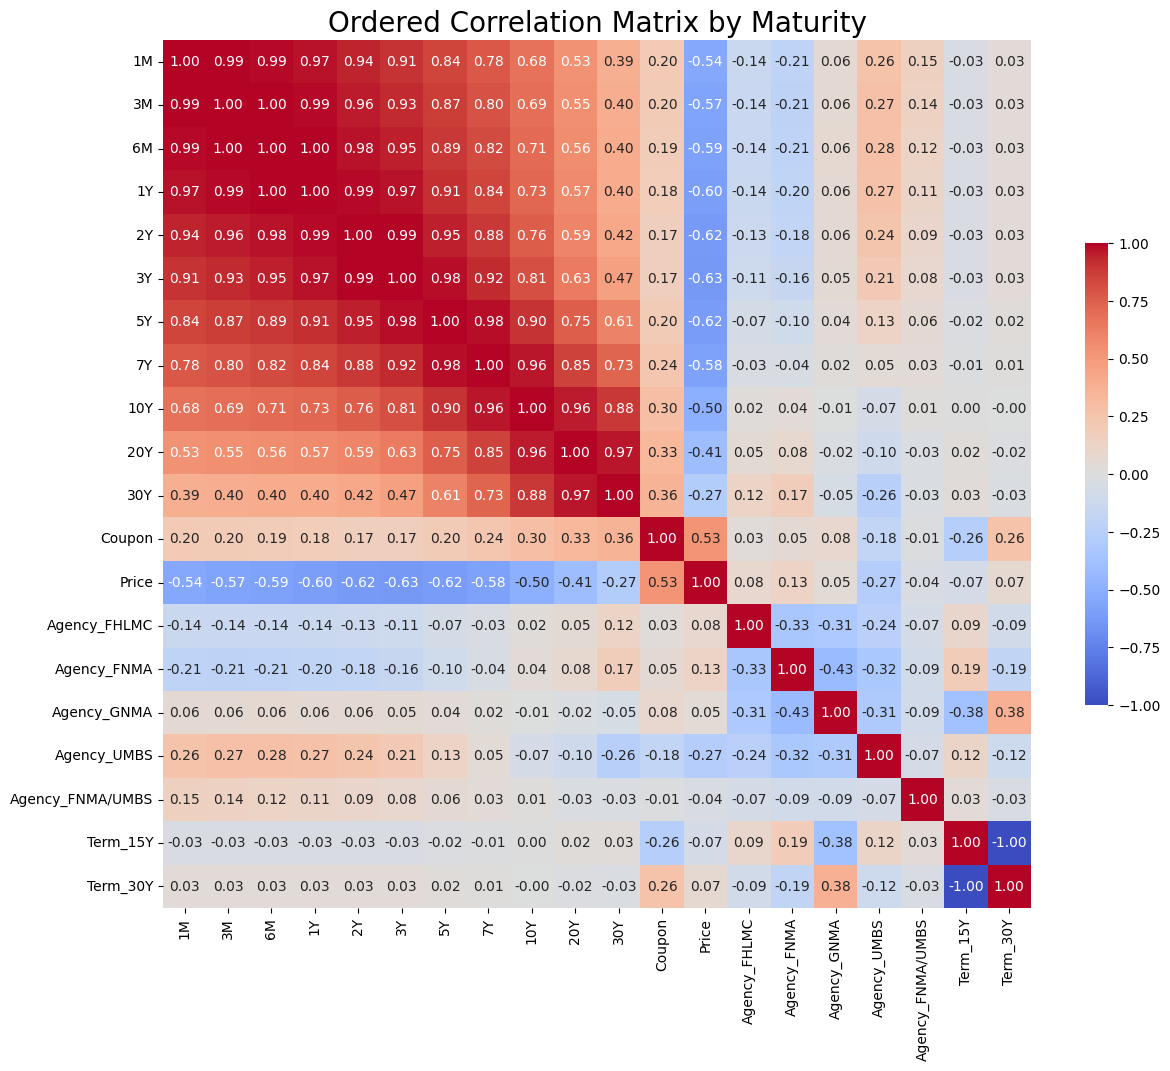

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data_encoded' is your DataFrame
# Order columns by maturity and any other columns of interest
ordered_columns = [
    '1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y',
    'Coupon', 'Price', 'Agency_FHLMC', 'Agency_FNMA', 'Agency_GNMA', 'Agency_UMBS', 'Agency_FNMA/UMBS', 'Term_15Y', 'Term_30Y'
]

# Reorder the correlation matrix
ordered_correlation_matrix = data_encoded[ordered_columns].corr()

# Visualize the ordered correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(ordered_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.title('Ordered Correlation Matrix by Maturity', fontsize=20)
plt.show()


Using Cross Validation

In [ ]:
from xgboost import cv
from xgboost import DMatrix

# Create a DMatrix from our features and target variable, as required by XGBoost for both training and validation
dtrain = DMatrix(X, label=y)

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Use regression with squared error
    'n_estimators': 10,
    'seed': 42  # For reproducibility
}

# Perform cross-validation
cv_results = cv(
    dtrain=dtrain,
    params=params,
    nfold=5,  # Number of folds in CV
    num_boost_round=10,  # Number of boosting rounds
    early_stopping_rounds=10,  # Stop if no improvement for 10 consecutive rounds
    metrics="rmse",  # Evaluate with Root Mean Squared Error
    as_pandas=True,
    seed=42  # For reproducibility
)

cv_results.tail(1)  # Display the last round of cross-validation results


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:36:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:36:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
9,0.697397,0.005204,0.703191,0.0126


In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming data_encoded is your preprocessed DataFrame

# Select columns for PCA and standardize them
pca_columns = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
X_pca = data_encoded[pca_columns]
X_std = StandardScaler().fit_transform(X_pca)

# Apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# Combine PCA components with other features if needed
X_final = pd.concat([principalDf, data_encoded.drop(pca_columns + ['Price'], axis=1)], axis=1)
y_final = data_encoded['Price']

# Split the dataset
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model_pca = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model_pca.fit(X_train_pca, y_train_pca)

# Predict and evaluate
y_pred_pca = rf_model_pca.predict(X_test_pca)
mae_pca = mean_absolute_error(y_test_pca, y_pred_pca)

print("Mean Absolute Error:", mae_pca)


Mean Absolute Error: 0.24529838333162382
